## Bibliotecas

In [ ]:
!pip install transformers

import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from torch.optim import AdamW

## Dataset

In [ ]:
dataset = pd.read_excel('drive/MyDrive/Datasets/Comentários.xlsx') # substituir pelo caminho do dataset natural
dataset_sintetico = pd.read_excel('drive/MyDrive/Datasets/Dados sintéticos.xlsx') # substituir pelo caminho do dataset sintético
dataset_sintetico = dataset_sintetico[dataset_sintetico['Emoção 1'] != 'neutro']
dataset = dataset[dataset['Emoção 1'] != 'neutro']

# Comentar ou remover o comentário de acordo com o objetivo de utilizar ou não a ajuda do dataset sintético
# combined_dataset = pd.concat([dataset, dataset_sintetico], ignore_index=True)
combined_dataset = pd.concat([dataset], ignore_index=True)


texts = combined_dataset['Comentário'].tolist()
labels = combined_dataset['Emoção 1'].tolist()


## Ajuste de dataset para o BERT

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = {label: i for i, label in enumerate(sorted(list(set(labels))))}

    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        label = self.label_map[label]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

## Montagem do classificador

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

## Define the train() function

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

## Construtor do avaliador

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

## Construtor do preditor

In [ ]:
def predict_sentiment(text, model, tokenizer, device, label_map, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, pred = torch.max(outputs, dim=1)
        inv_label_map = {v: k for k, v in label_map.items()}
        return inv_label_map[pred.item()]


## Personalizar parametos do modelo

In [ ]:
# Set up parameters
bert_model_name = 'neuralmind/bert-base-portuguese-cased'
num_classes = 2
max_length = 150
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

## Separação de dados

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

## Parametros do modelo 2

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

## Configuração Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming you have 7 unique classes in your dataset (0 to 6)
num_classes = len(train_dataset.label_map) # update the parameter during model initialization based on the label_map

# Initialize the model with the correct number of classes
model = BERTClassifier(bert_model_name, num_classes).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

##  Treinamento do modelo

In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5591
              precision    recall  f1-score   support

           0       0.52      0.89      0.66       128
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00        10
           3       0.62      0.62      0.62       130
           4       0.00      0.00      0.00        50
           5       0.58      0.47      0.52        70

    accuracy                           0.56       406
   macro avg       0.29      0.33      0.30       406
weighted avg       0.46      0.56      0.49       406

Epoch 2/4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.6281
              precision    recall  f1-score   support

           0       0.61      0.89      0.72       128
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00        10
           3       0.67      0.69      0.68       130
           4       0.52      0.30      0.38        50
           5       0.64      0.51      0.57        70

    accuracy                           0.63       406
   macro avg       0.41      0.40      0.39       406
weighted avg       0.58      0.63      0.59       406

Epoch 3/4
Validation Accuracy: 0.6502
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       128
           1       1.00      0.06      0.11        18
           2       0.50      0.20      0.29        10
           3       0.72      0.69      0.71       130
           4       0.53      0.60      0.56        50
           5       0.56      0.59      0.57        70

    accurac

Saving the final model

In [ ]:
torch.save(model.state_dict(), "bert_classifier.pth")

## Avaliação do modelo

In [ ]:
print("=== Avaliação final no conjunto de validação ===")
final_accuracy, final_report = evaluate(model, val_dataloader, device)
print(f"Acurácia final: {final_accuracy:.4f}")
print(final_report)


=== Avaliação final no conjunto de validação ===
Acurácia final: 0.6552
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       128
           1       1.00      0.11      0.20        18
           2       0.67      0.40      0.50        10
           3       0.70      0.71      0.70       130
           4       0.53      0.60      0.56        50
           5       0.58      0.54      0.56        70

    accuracy                           0.66       406
   macro avg       0.69      0.52      0.54       406
weighted avg       0.67      0.66      0.64       406



In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    accuracy = accuracy_score(actual_labels, predictions)
    report = classification_report(actual_labels, predictions)
    return accuracy, report, actual_labels, predictions


=== Avaliação final no conjunto de validação ===
Acurácia final: 0.6552
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       128
           1       1.00      0.11      0.20        18
           2       0.67      0.40      0.50        10
           3       0.70      0.71      0.70       130
           4       0.53      0.60      0.56        50
           5       0.58      0.54      0.56        70

    accuracy                           0.66       406
   macro avg       0.69      0.52      0.54       406
weighted avg       0.67      0.66      0.64       406



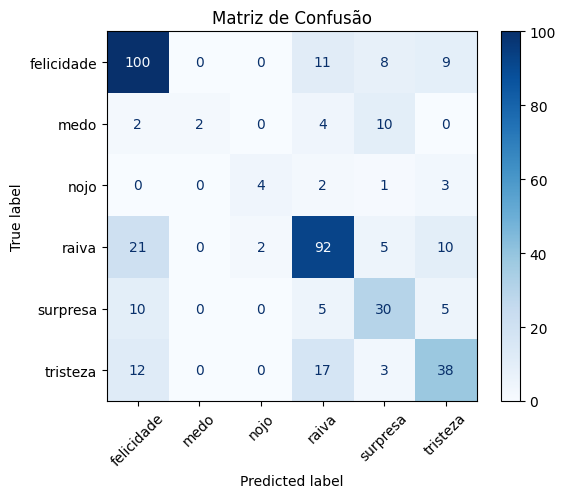

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("=== Avaliação final no conjunto de validação ===")
final_accuracy, final_report, y_true, y_pred = evaluate(model, val_dataloader, device)
print(f"Acurácia final: {final_accuracy:.4f}")
print(final_report)

# Gera e exibe a matriz
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.label_map.keys())
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()
